# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.74KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

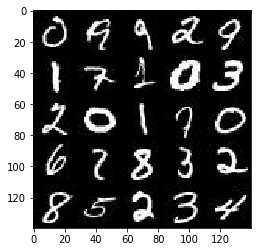

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

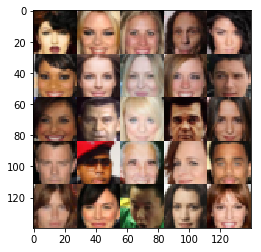

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    
    return input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * x1, x1)
        # 16x16x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        outputs = tf.sigmoid(logits)
        
    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Set the image width, height, and image channels
    _, image_width, image_height, image_channels = data_shape
    
    # Impliment model_inputs and set the input_real, input_z, and learning rate
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Impliment model_loss and set the d_loss and g_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Impliment model_opt and set d_train_opt and g_train_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Set batch counter
    batch_count = 0
    
    # Set number of images to print
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images*2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch_count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1938... Generator Loss: 2.2779
Epoch 1/2... Discriminator Loss: 0.2273... Generator Loss: 5.2690
Epoch 1/2... Discriminator Loss: 0.3161... Generator Loss: 2.8904
Epoch 1/2... Discriminator Loss: 0.5043... Generator Loss: 3.0937
Epoch 1/2... Discriminator Loss: 0.4726... Generator Loss: 2.8008
Epoch 1/2... Discriminator Loss: 0.3160... Generator Loss: 1.9522
Epoch 1/2... Discriminator Loss: 0.6978... Generator Loss: 1.2074
Epoch 1/2... Discriminator Loss: 0.3765... Generator Loss: 3.1642
Epoch 1/2... Discriminator Loss: 0.8678... Generator Loss: 3.8911
Epoch 1/2... Discriminator Loss: 0.4651... Generator Loss: 1.4283


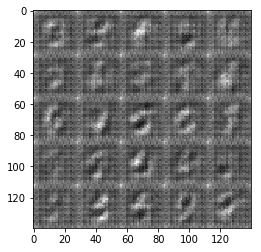

Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 0.9912
Epoch 1/2... Discriminator Loss: 0.5282... Generator Loss: 1.3079
Epoch 1/2... Discriminator Loss: 2.2991... Generator Loss: 0.1500
Epoch 1/2... Discriminator Loss: 0.5873... Generator Loss: 1.3000
Epoch 1/2... Discriminator Loss: 0.6444... Generator Loss: 1.1634
Epoch 1/2... Discriminator Loss: 0.5250... Generator Loss: 2.2830
Epoch 1/2... Discriminator Loss: 0.7474... Generator Loss: 0.8568
Epoch 1/2... Discriminator Loss: 0.4398... Generator Loss: 2.0735
Epoch 1/2... Discriminator Loss: 0.6072... Generator Loss: 2.5474
Epoch 1/2... Discriminator Loss: 0.9146... Generator Loss: 3.3277


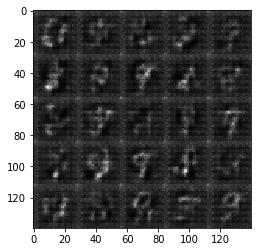

Epoch 1/2... Discriminator Loss: 0.5125... Generator Loss: 1.2131
Epoch 1/2... Discriminator Loss: 0.5094... Generator Loss: 1.2232
Epoch 1/2... Discriminator Loss: 0.6379... Generator Loss: 3.0971
Epoch 1/2... Discriminator Loss: 0.3520... Generator Loss: 1.7053
Epoch 1/2... Discriminator Loss: 0.3554... Generator Loss: 2.2400
Epoch 1/2... Discriminator Loss: 0.3953... Generator Loss: 2.7433
Epoch 1/2... Discriminator Loss: 1.6810... Generator Loss: 0.2486
Epoch 1/2... Discriminator Loss: 0.3742... Generator Loss: 1.7003
Epoch 1/2... Discriminator Loss: 0.5626... Generator Loss: 3.1809
Epoch 1/2... Discriminator Loss: 0.5838... Generator Loss: 1.0218


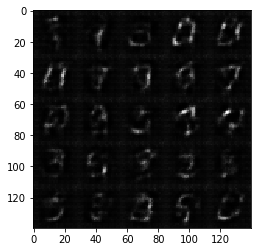

Epoch 1/2... Discriminator Loss: 0.2572... Generator Loss: 2.0373
Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 4.0616
Epoch 1/2... Discriminator Loss: 0.5177... Generator Loss: 2.2480
Epoch 1/2... Discriminator Loss: 0.4442... Generator Loss: 1.9480
Epoch 1/2... Discriminator Loss: 0.3011... Generator Loss: 2.2915
Epoch 1/2... Discriminator Loss: 0.3098... Generator Loss: 2.0078
Epoch 1/2... Discriminator Loss: 0.3339... Generator Loss: 2.3051
Epoch 1/2... Discriminator Loss: 0.3858... Generator Loss: 2.4975
Epoch 1/2... Discriminator Loss: 0.8934... Generator Loss: 4.2011
Epoch 1/2... Discriminator Loss: 0.3709... Generator Loss: 1.7210


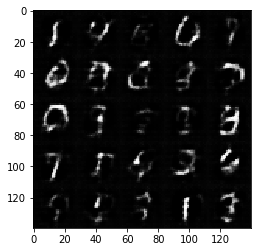

Epoch 1/2... Discriminator Loss: 0.3554... Generator Loss: 1.9421
Epoch 1/2... Discriminator Loss: 0.6252... Generator Loss: 0.9418
Epoch 1/2... Discriminator Loss: 0.2872... Generator Loss: 2.6321
Epoch 1/2... Discriminator Loss: 0.7543... Generator Loss: 4.0592
Epoch 1/2... Discriminator Loss: 0.7811... Generator Loss: 1.8153
Epoch 1/2... Discriminator Loss: 0.5705... Generator Loss: 1.8472
Epoch 2/2... Discriminator Loss: 0.6033... Generator Loss: 1.8850
Epoch 2/2... Discriminator Loss: 0.3806... Generator Loss: 1.8864
Epoch 2/2... Discriminator Loss: 0.4954... Generator Loss: 1.2933
Epoch 2/2... Discriminator Loss: 0.3897... Generator Loss: 1.6412


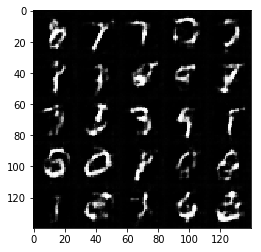

Epoch 2/2... Discriminator Loss: 0.4538... Generator Loss: 2.1142
Epoch 2/2... Discriminator Loss: 0.3232... Generator Loss: 1.9902
Epoch 2/2... Discriminator Loss: 0.3682... Generator Loss: 2.0492
Epoch 2/2... Discriminator Loss: 0.5641... Generator Loss: 1.0333
Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 0.4485... Generator Loss: 1.4127
Epoch 2/2... Discriminator Loss: 0.4381... Generator Loss: 1.3968
Epoch 2/2... Discriminator Loss: 0.3831... Generator Loss: 1.6163
Epoch 2/2... Discriminator Loss: 0.4193... Generator Loss: 1.4582
Epoch 2/2... Discriminator Loss: 0.4218... Generator Loss: 1.5634


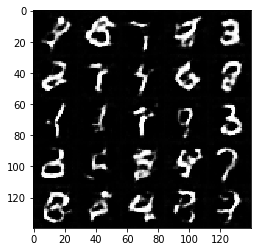

Epoch 2/2... Discriminator Loss: 0.3629... Generator Loss: 1.7817


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2415... Generator Loss: 2.2731
Epoch 1/1... Discriminator Loss: 0.1116... Generator Loss: 5.0427
Epoch 1/1... Discriminator Loss: 0.1059... Generator Loss: 4.0445
Epoch 1/1... Discriminator Loss: 0.2825... Generator Loss: 1.7536
Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 6.2953
Epoch 1/1... Discriminator Loss: 2.6201... Generator Loss: 11.2512
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 4.6164
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 5.0247
Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 1.3390
Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 0.7000


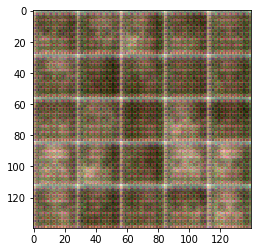

Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 2.2948
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 1.2818
Epoch 1/1... Discriminator Loss: 0.2261... Generator Loss: 2.7543
Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 1.7401
Epoch 1/1... Discriminator Loss: 0.1809... Generator Loss: 3.3148
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 0.5389... Generator Loss: 1.4868
Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 1.4465
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 2.3751
Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 2.3000


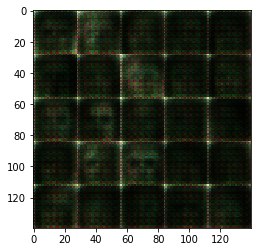

Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 3.8204
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 1.6804
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.8222
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 1.9249
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 3.2921
Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 2.2195
Epoch 1/1... Discriminator Loss: 0.5887... Generator Loss: 1.1953
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.6299


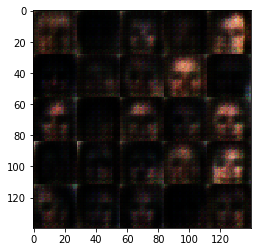

Epoch 1/1... Discriminator Loss: 0.5223... Generator Loss: 2.4324
Epoch 1/1... Discriminator Loss: 0.6758... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.4087
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 3.4013
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 3.7325
Epoch 1/1... Discriminator Loss: 0.4035... Generator Loss: 1.9388
Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 2.5284
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 2.4926


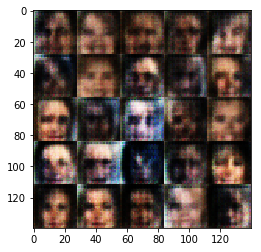

Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.2793
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 2.4530... Generator Loss: 4.8864
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 3.5132
Epoch 1/1... Discriminator Loss: 0.8886... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 1.3336
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 2.8189
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 2.2621


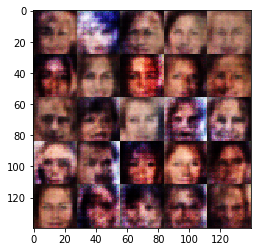

Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 2.5324
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 2.8808
Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.5320
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 0.8744... Generator Loss: 1.2338
Epoch 1/1... Discriminator Loss: 1.6331... Generator Loss: 0.3254
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 1.7617
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.8661
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 0.9887


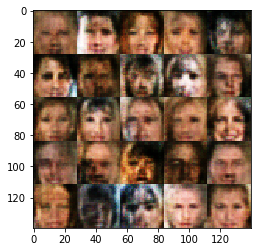

Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 1.9587
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 2.3557
Epoch 1/1... Discriminator Loss: 1.5695... Generator Loss: 0.3231
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 1.4163
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 2.3915
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 2.6046


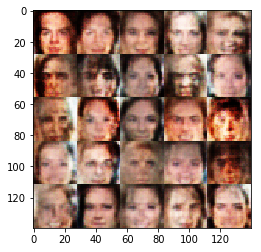

Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.2878
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.3558
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 2.1978
Epoch 1/1... Discriminator Loss: 0.7612... Generator Loss: 1.4048
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 1.6313
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.1967
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 0.8100


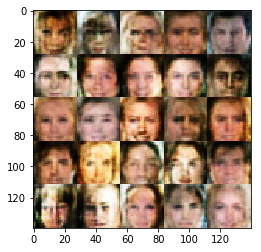

Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.2869
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 1.5818
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 1.5156
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 2.1697
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.7541
Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 1.1592
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 0.8772... Generator Loss: 0.9023


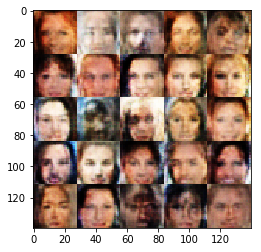

Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.3564
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 1.8082


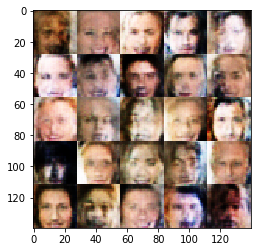

Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.4573
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.5145
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 2.3208
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.9282... Generator Loss: 0.2413
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 2.9188
Epoch 1/1... Discriminator Loss: 0.9191... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 1.8840


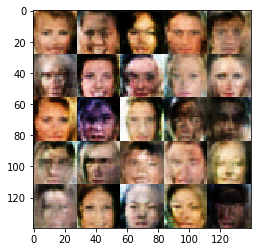

Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 0.6292... Generator Loss: 3.2532
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 1.7270
Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 1.9990
Epoch 1/1... Discriminator Loss: 0.4955... Generator Loss: 1.7940
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 4.8370


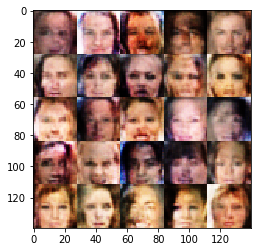

Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.4173
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 1.5620
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 2.9588
Epoch 1/1... Discriminator Loss: 0.4788... Generator Loss: 1.5959
Epoch 1/1... Discriminator Loss: 0.6299... Generator Loss: 2.1931
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 3.3140
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 2.5478... Generator Loss: 0.1603
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.5668


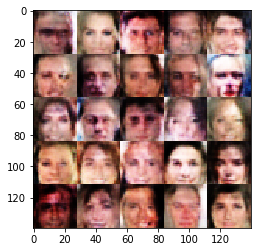

Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 1.2281
Epoch 1/1... Discriminator Loss: 0.6685... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 0.6080... Generator Loss: 2.1497
Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 1.4659
Epoch 1/1... Discriminator Loss: 0.5309... Generator Loss: 2.0891
Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 1.4635
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 2.4490
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 3.5015
Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 1.2167
Epoch 1/1... Discriminator Loss: 0.2995... Generator Loss: 2.2712


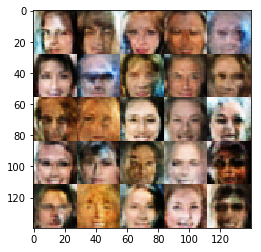

Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.6158
Epoch 1/1... Discriminator Loss: 0.1335... Generator Loss: 3.8171
Epoch 1/1... Discriminator Loss: 0.2865... Generator Loss: 2.2477
Epoch 1/1... Discriminator Loss: 0.2888... Generator Loss: 2.3601
Epoch 1/1... Discriminator Loss: 0.4913... Generator Loss: 1.4652
Epoch 1/1... Discriminator Loss: 0.2563... Generator Loss: 2.5368
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 1.7223
Epoch 1/1... Discriminator Loss: 0.3706... Generator Loss: 2.2931
Epoch 1/1... Discriminator Loss: 0.2445... Generator Loss: 3.3558
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 3.6061


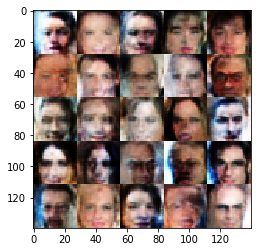

Epoch 1/1... Discriminator Loss: 0.3594... Generator Loss: 4.3467
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 2.1163... Generator Loss: 0.2192
Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 3.3437
Epoch 1/1... Discriminator Loss: 0.1616... Generator Loss: 3.9448
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 1.5951
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 1.5721
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 0.2767... Generator Loss: 2.1347


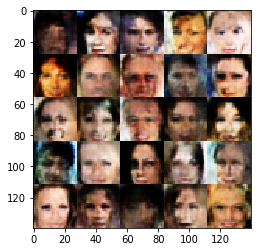

Epoch 1/1... Discriminator Loss: 0.1996... Generator Loss: 4.0825
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 7.3063
Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 3.0083
Epoch 1/1... Discriminator Loss: 0.2214... Generator Loss: 2.6253
Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 0.1578... Generator Loss: 4.4158
Epoch 1/1... Discriminator Loss: 0.1573... Generator Loss: 3.2299
Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 3.3960
Epoch 1/1... Discriminator Loss: 0.6077... Generator Loss: 4.4763
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 1.2425


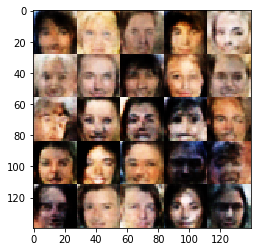

Epoch 1/1... Discriminator Loss: 0.2245... Generator Loss: 2.8174
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 0.2892... Generator Loss: 2.0156
Epoch 1/1... Discriminator Loss: 0.3677... Generator Loss: 3.2041
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 1.2882
Epoch 1/1... Discriminator Loss: 0.2397... Generator Loss: 4.0248
Epoch 1/1... Discriminator Loss: 0.2190... Generator Loss: 2.6559
Epoch 1/1... Discriminator Loss: 0.1794... Generator Loss: 2.3172
Epoch 1/1... Discriminator Loss: 0.2587... Generator Loss: 2.1971
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 3.0001


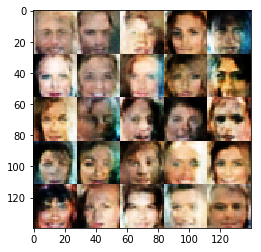

Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 1.3495
Epoch 1/1... Discriminator Loss: 0.2008... Generator Loss: 2.5082
Epoch 1/1... Discriminator Loss: 0.4525... Generator Loss: 2.9191
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 0.1338... Generator Loss: 2.8995
Epoch 1/1... Discriminator Loss: 0.2177... Generator Loss: 3.2415
Epoch 1/1... Discriminator Loss: 0.1825... Generator Loss: 2.1877
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 0.1636... Generator Loss: 2.4195
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.5020


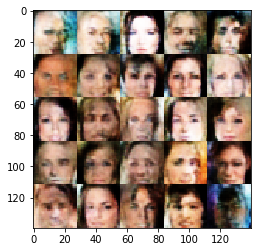

Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 1.5804
Epoch 1/1... Discriminator Loss: 0.2783... Generator Loss: 3.8860
Epoch 1/1... Discriminator Loss: 0.2163... Generator Loss: 2.2080
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 0.2031... Generator Loss: 2.7922
Epoch 1/1... Discriminator Loss: 0.5934... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 0.4098... Generator Loss: 1.4655
Epoch 1/1... Discriminator Loss: 0.6318... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 0.1800... Generator Loss: 2.6339
Epoch 1/1... Discriminator Loss: 0.0741... Generator Loss: 4.3906


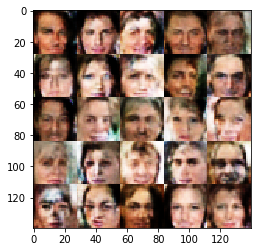

Epoch 1/1... Discriminator Loss: 0.2316... Generator Loss: 3.3911
Epoch 1/1... Discriminator Loss: 0.1853... Generator Loss: 3.1411
Epoch 1/1... Discriminator Loss: 0.1664... Generator Loss: 2.9372
Epoch 1/1... Discriminator Loss: 0.1602... Generator Loss: 3.4916
Epoch 1/1... Discriminator Loss: 3.4679... Generator Loss: 5.9534
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 0.1792... Generator Loss: 2.3312
Epoch 1/1... Discriminator Loss: 0.2519... Generator Loss: 4.0292
Epoch 1/1... Discriminator Loss: 0.2771... Generator Loss: 2.0139


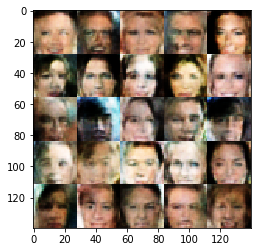

Epoch 1/1... Discriminator Loss: 0.2470... Generator Loss: 2.2472
Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 1.4434
Epoch 1/1... Discriminator Loss: 0.1434... Generator Loss: 2.4028
Epoch 1/1... Discriminator Loss: 0.2182... Generator Loss: 2.1935
Epoch 1/1... Discriminator Loss: 0.1242... Generator Loss: 2.7784
Epoch 1/1... Discriminator Loss: 0.2996... Generator Loss: 1.7116
Epoch 1/1... Discriminator Loss: 0.3177... Generator Loss: 3.0276
Epoch 1/1... Discriminator Loss: 0.3022... Generator Loss: 2.0942
Epoch 1/1... Discriminator Loss: 0.2617... Generator Loss: 3.4346
Epoch 1/1... Discriminator Loss: 0.1569... Generator Loss: 2.5010


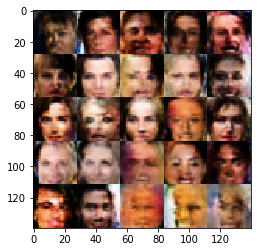

Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 0.1340... Generator Loss: 4.4073
Epoch 1/1... Discriminator Loss: 2.6387... Generator Loss: 3.6182
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 2.6615
Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 1.5225
Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 2.4491... Generator Loss: 0.1708
Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 0.2855... Generator Loss: 1.8167
Epoch 1/1... Discriminator Loss: 0.1772... Generator Loss: 3.2400


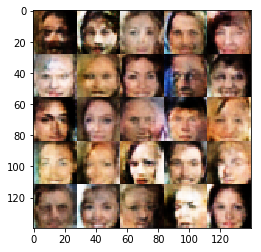

Epoch 1/1... Discriminator Loss: 0.2922... Generator Loss: 2.0548
Epoch 1/1... Discriminator Loss: 0.2465... Generator Loss: 2.1645
Epoch 1/1... Discriminator Loss: 0.1071... Generator Loss: 3.7452
Epoch 1/1... Discriminator Loss: 2.5973... Generator Loss: 0.1796
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 2.5626
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 1.5206
Epoch 1/1... Discriminator Loss: 0.3055... Generator Loss: 1.8501
Epoch 1/1... Discriminator Loss: 0.2304... Generator Loss: 2.0746
Epoch 1/1... Discriminator Loss: 0.2078... Generator Loss: 3.2645
Epoch 1/1... Discriminator Loss: 0.1853... Generator Loss: 2.7041


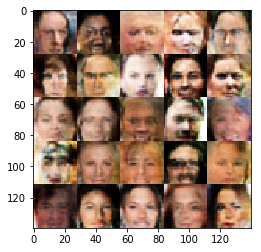

Epoch 1/1... Discriminator Loss: 0.1726... Generator Loss: 2.5043
Epoch 1/1... Discriminator Loss: 0.1433... Generator Loss: 3.1621
Epoch 1/1... Discriminator Loss: 0.1494... Generator Loss: 2.7104
Epoch 1/1... Discriminator Loss: 0.2502... Generator Loss: 2.2995
Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 2.7216
Epoch 1/1... Discriminator Loss: 0.2216... Generator Loss: 3.1930
Epoch 1/1... Discriminator Loss: 0.2466... Generator Loss: 2.4065
Epoch 1/1... Discriminator Loss: 0.2072... Generator Loss: 4.8580
Epoch 1/1... Discriminator Loss: 0.2644... Generator Loss: 4.3324
Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 5.7488


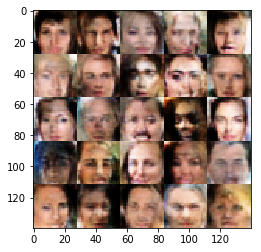

Epoch 1/1... Discriminator Loss: 1.8778... Generator Loss: 1.3263
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 2.7858
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 0.5311... Generator Loss: 1.3026
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.0268
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 1.2854
Epoch 1/1... Discriminator Loss: 0.4244... Generator Loss: 2.0226


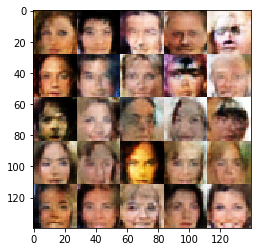

Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 0.2590... Generator Loss: 3.2174
Epoch 1/1... Discriminator Loss: 0.2671... Generator Loss: 2.0739
Epoch 1/1... Discriminator Loss: 0.3049... Generator Loss: 2.1213
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 1.9405
Epoch 1/1... Discriminator Loss: 0.1564... Generator Loss: 3.3950
Epoch 1/1... Discriminator Loss: 0.2298... Generator Loss: 2.5465
Epoch 1/1... Discriminator Loss: 0.4357... Generator Loss: 1.4428
Epoch 1/1... Discriminator Loss: 0.1437... Generator Loss: 3.2103
Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 1.4206


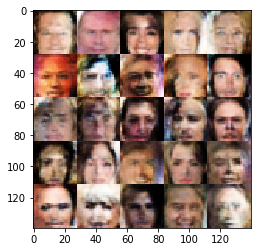

Epoch 1/1... Discriminator Loss: 0.2684... Generator Loss: 2.5634
Epoch 1/1... Discriminator Loss: 0.0955... Generator Loss: 4.3360
Epoch 1/1... Discriminator Loss: 0.1759... Generator Loss: 2.5202
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 4.7152
Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 2.1546
Epoch 1/1... Discriminator Loss: 1.7405... Generator Loss: 0.3238
Epoch 1/1... Discriminator Loss: 0.5053... Generator Loss: 2.7607
Epoch 1/1... Discriminator Loss: 1.8009... Generator Loss: 0.2915
Epoch 1/1... Discriminator Loss: 0.1757... Generator Loss: 2.8472
Epoch 1/1... Discriminator Loss: 0.1722... Generator Loss: 2.5637


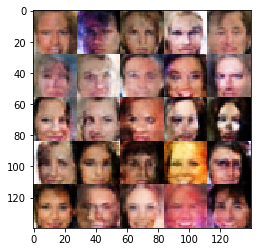

Epoch 1/1... Discriminator Loss: 0.1232... Generator Loss: 3.0294
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 1.3082
Epoch 1/1... Discriminator Loss: 0.2144... Generator Loss: 2.4399
Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 1.5866
Epoch 1/1... Discriminator Loss: 0.2161... Generator Loss: 2.2560
Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 1.9562
Epoch 1/1... Discriminator Loss: 0.1709... Generator Loss: 2.4106
Epoch 1/1... Discriminator Loss: 0.2464... Generator Loss: 4.6107
Epoch 1/1... Discriminator Loss: 0.5842... Generator Loss: 1.3909
Epoch 1/1... Discriminator Loss: 0.5371... Generator Loss: 1.7237


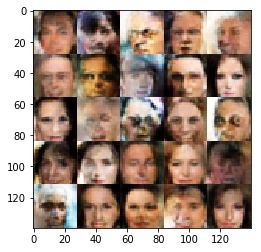

Epoch 1/1... Discriminator Loss: 1.8998... Generator Loss: 0.2102
Epoch 1/1... Discriminator Loss: 0.3269... Generator Loss: 2.0837
Epoch 1/1... Discriminator Loss: 0.2311... Generator Loss: 2.5181
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 0.3211... Generator Loss: 1.6603
Epoch 1/1... Discriminator Loss: 0.2887... Generator Loss: 2.0736
Epoch 1/1... Discriminator Loss: 0.1728... Generator Loss: 3.9386
Epoch 1/1... Discriminator Loss: 0.2420... Generator Loss: 2.0117
Epoch 1/1... Discriminator Loss: 0.1346... Generator Loss: 3.0124
Epoch 1/1... Discriminator Loss: 0.2019... Generator Loss: 4.0428


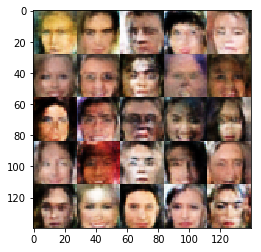

Epoch 1/1... Discriminator Loss: 0.2618... Generator Loss: 2.1888
Epoch 1/1... Discriminator Loss: 0.2595... Generator Loss: 2.0123
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 1.6991... Generator Loss: 0.2871
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 4.3428
Epoch 1/1... Discriminator Loss: 0.5708... Generator Loss: 1.2973
Epoch 1/1... Discriminator Loss: 0.3352... Generator Loss: 1.7914
Epoch 1/1... Discriminator Loss: 0.2713... Generator Loss: 1.9733
Epoch 1/1... Discriminator Loss: 0.1755... Generator Loss: 2.7716
Epoch 1/1... Discriminator Loss: 0.3018... Generator Loss: 2.7195


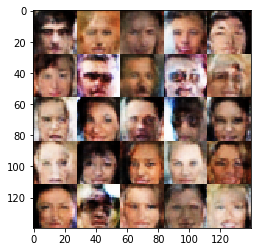

Epoch 1/1... Discriminator Loss: 0.2448... Generator Loss: 1.9866
Epoch 1/1... Discriminator Loss: 0.1151... Generator Loss: 4.1791
Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 3.3950
Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 0.2432... Generator Loss: 2.0927
Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 0.9901


In [33]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.